In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools
from tools import cmp

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [5]:
# read in the crowley data
adata = sc.read_h5ad('dataset/Chen/chen_11_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 41516 × 4624
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden', 'leiden_R', 'celltypes'
    var: 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltypes_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
mnp = sc.read_h5ad('dataset/Chen/chen_11_filtered_mnp_ingested.h5ad')
mnp

AnnData object with n_obs × n_vars = 9565 × 2939
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden', 'leiden_R', 'celltypes', 'celltype-immune'
    var: 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltypes_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'

In [7]:
lymphoid = sc.read_h5ad('dataset/Chen/chen_11_filtered_lymphoid_annotated.h5ad')
lymphoid

AnnData object with n_obs × n_vars = 18269 × 4040
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden', 'leiden_R', 'celltypes'
    var: 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltypes_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
# make a dictionary of celltypes
celltype_dict = dict(zip(adata.obs_names, adata.obs['celltypes']))
# update with MNP and lymphoid annotations
celltype_dict.update(dict(zip(mnp.obs_names, mnp.obs['celltype-immune'])))
celltype_dict.update(dict(zip(lymphoid.obs_names, lymphoid.obs['celltypes'])))

In [9]:
# keep the current colors
color_dict = dict(zip(adata.obs['celltypes'].cat.categories, adata.uns['celltypes_colors']))
color_dict.update(dict(zip(mnp.obs['celltype-immune'].cat.categories, mnp.uns['celltype-immune_colors'])))
color_dict.update(dict(zip(lymphoid.obs['celltypes'].cat.categories, lymphoid.uns['celltypes_colors'])))
color_dict.update({'Myofibroblast':'#004529'})

In [10]:
adata.obs['celltypes'] = pd.Series(celltype_dict)

... storing 'celltypes' as categorical


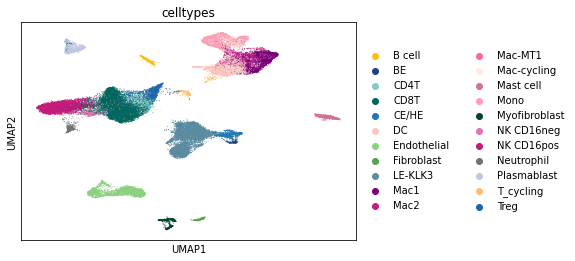

In [11]:
sc.pl.umap(adata, color = 'celltypes', palette = color_dict)

In [12]:
adata.obs['celltypes'] = adata.obs['celltypes'].astype('category')
adata.obs['celltypes'] = adata.obs['celltypes'].cat.reorder_categories([
    'BE',
    'CE/HE',
    'LE-KLK3',
    'Myofibroblast',
    'Fibroblast',
    'Endothelial',
    'Mast cell',
    'Mac1',
    'Mac2',
    'Mac-MT1',
    'Mono',
    'DC',
    'Mac-cycling',
    'CD8T',
    'CD4T',
    'Treg',
    'T_cycling',
    'NK CD16neg',
    'NK CD16pos',
    'B cell',
    'Plasmablast',
    'Neutrophil',])

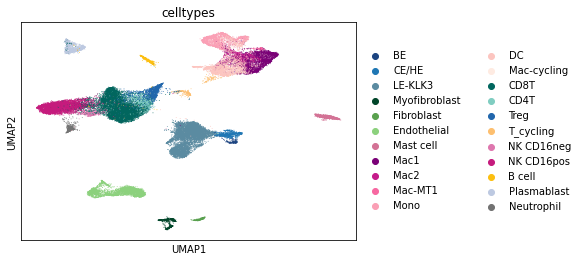

In [13]:
sc.pl.umap(adata, color = 'celltypes', palette = color_dict)

In [14]:
main_dict={'BE':'BE',
    'CE/HE':'CE/HE',
    'LE-KLK3':'LE-KLK3',
    'Myofibroblast':'Myofibroblast',
    'Fibroblast':'Fibroblast',
    'Endothelial':'Endothelial',
    'Mast cell':'Mast cell',
    'Mac1':'MNP',
    'Mac2':'MNP',
    'Mac-MT1':'MNP',
    'Mono':'MNP',
    'DC':'MNP',
    'Mac-cycling':'MNP',
    'CD8T':'T cell',
    'CD4T':'T cell',
    'Treg':'T cell',
    'T_cycling':'T cell',
    'NK CD16neg':'NK cell',
    'NK CD16pos':'NK cell',
    'B cell':'B cell',
    'Plasmablast':'Plasmablast',
    'Neutrophil':'Neutrophil',}
cols = {
    'BE':'#1c4481',
    'CE/HE':'#1f77b4',
    'LE-KLK3':'#5b8ba1',
    'Myofibroblast':'#004529',
    'Fibroblast':'#59a14f',
    'Endothelial':'#8cd17d',
    'MNP': '#c7233b',
    'Mast cell': '#d37295',
    'NK cell': '#ff9d9a',
    'T cell':'#f28e2b',
    'B cell':'#fcbf10',
    'Plasmablast': '#bdc9e1',
    'Neutrophil':'#727272',
       }
adata.obs['celltypes_group'] = [main_dict[l] for l in adata.obs['celltypes']]
adata.obs['celltypes_group'] = adata.obs['celltypes_group'].astype('category')
adata.obs['celltypes_group'] = adata.obs['celltypes_group'].cat.reorder_categories([k for k in cols.keys() if k in list(adata.obs['celltypes_group'])])

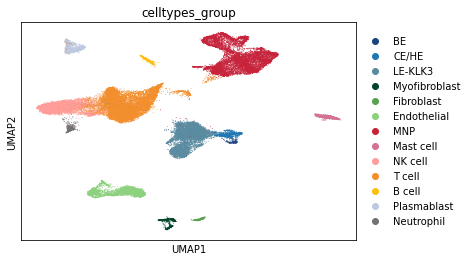

In [15]:
sc.pl.umap(adata, color = 'celltypes_group', palette = cols)

In [16]:
# save
adata.write_h5ad('dataset/Chen/chen_11_filtered.h5ad', compression = 'gzip')